In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import warnings
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [3]:
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (12,6)


In [4]:
solar_data = pd.read_csv("/content/gdrive/MyDrive/SolarPrediction.csv")
solar_data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [5]:
solar_data.rename(columns={'Data': 'Date'}, inplace=True)

In [6]:
solar_data.head()

,UNIXTime,Date,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [7]:
solar_data.shape

(32686, 11)

In [8]:
solar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Date                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


In [9]:
solar_df = solar_data.copy()

In [10]:
data_series = pd.to_datetime(solar_df['Date'])
solar_df['Month_Extracted'] = data_series.dt.month
solar_df['Year_Extracted'] = data_series.dt.year

time_series = pd.to_datetime(solar_df['Time'])
solar_df['Hour_Extracted'] = time_series.dt.hour

In [11]:
solar_df.head()

,UNIXTime,Date,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month_Extracted,Year_Extracted,Hour_Extracted
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,2016,23
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,2016,23
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,2016,23
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,2016,23
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,2016,23


In [12]:
# Function to extract hour and minute
def extract_time_components(time_str):
    hour = int(re.search(r'^\d+', time_str).group(0))
    minute = int(re.search(r'(?<=\:)\d+(?=\:)', time_str).group(0))
    return hour, minute

solar_df['SunRise_Hour'], solar_df['SunRise_Minute'] = zip(*solar_df['TimeSunRise'].apply(extract_time_components))
solar_df['SunSet_Hour'], solar_df['SunSet_Minute'] = zip(*solar_df['TimeSunSet'].apply(extract_time_components))

In [13]:
# Calculate sun duration
solar_df['SunDuration_minutes'] = (solar_df['SunSet_Hour'] * 60 + solar_df['SunSet_Minute']) - (solar_df['SunRise_Hour'] * 60 + solar_df['SunRise_Minute'])
solar_df.head()


,UNIXTime,Date,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month_Extracted,Year_Extracted,Hour_Extracted,SunRise_Hour,SunRise_Minute,SunSet_Hour,SunSet_Minute,SunDuration_minutes
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,2016,23,6,13,18,13,720
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,2016,23,6,13,18,13,720
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,2016,23,6,13,18,13,720
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,2016,23,6,13,18,13,720
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,2016,23,6,13,18,13,720


In [14]:
solar_df.drop(['UNIXTime', 'Date', 'Time', 'TimeSunRise', 'TimeSunSet'], axis = 1, inplace = True)

In [15]:
solar_df.shape

(32686, 14)

In [16]:
solar_df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month_Extracted,Year_Extracted,Hour_Extracted,SunRise_Hour,SunRise_Minute,SunSet_Hour,SunSet_Minute,SunDuration_minutes
0,1.21,48,30.46,59,177.39,5.62,9,2016,23,6,13,18,13,720
1,1.21,48,30.46,58,176.78,3.37,9,2016,23,6,13,18,13,720
2,1.23,48,30.46,57,158.75,3.37,9,2016,23,6,13,18,13,720
3,1.21,48,30.46,60,137.71,3.37,9,2016,23,6,13,18,13,720
4,1.17,48,30.46,62,104.95,5.62,9,2016,23,6,13,18,13,720


In [17]:
np.array(solar_df['Radiation'])

array([1.21, 1.21, 1.23, ..., 1.2 , 1.23, 1.2 ])

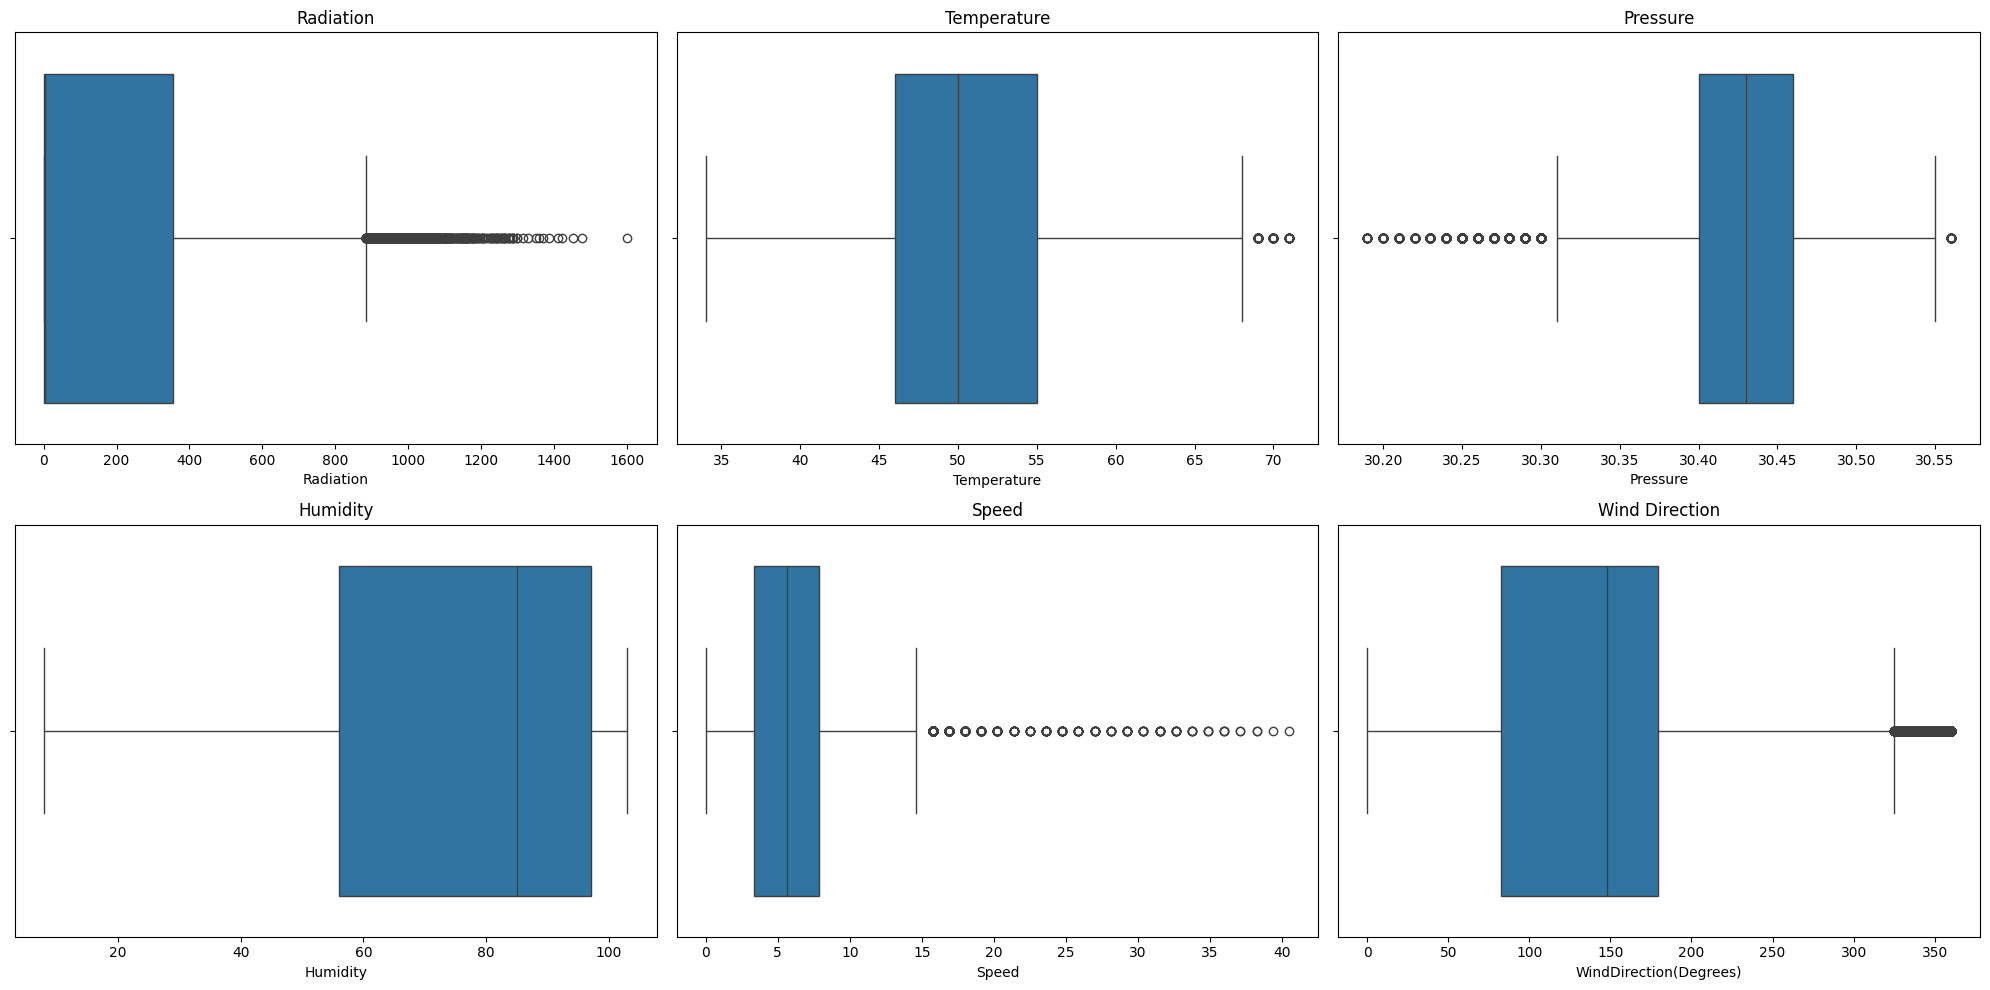

In [18]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
sns.boxplot(x=solar_df['Radiation'])
plt.title('Radiation')

plt.subplot(2, 3, 2)
sns.boxplot(x=solar_df['Temperature'])
plt.title('Temperature')

plt.subplot(2, 3, 3)
sns.boxplot(x=solar_df['Pressure'])
plt.title('Pressure')

plt.subplot(2, 3, 4)
sns.boxplot(x=solar_df['Humidity'])
plt.title('Humidity')

plt.subplot(2, 3, 5)
sns.boxplot(x=solar_df['Speed'])
plt.title('Speed')

plt.subplot(2, 3, 6)
sns.boxplot(x=solar_df['WindDirection(Degrees)'])
plt.title('Wind Direction')

plt.tight_layout()
plt.show()

In [19]:
Q1 = solar_df['Radiation'].quantile(0.25)
Q3 = solar_df['Radiation'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
solar_df = solar_df[(solar_df['Radiation'] >= lower_bound) & (solar_df['Radiation'] <= upper_bound)]

Q1 = solar_df['Temperature'].quantile(0.25)
Q3 = solar_df['Temperature'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
solar_df = solar_df[(solar_df['Temperature'] >= lower_bound) & (solar_df['Temperature'] <= upper_bound)]

Q1 = solar_df['Pressure'].quantile(0.25)
Q3 = solar_df['Pressure'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
solar_df = solar_df[(solar_df['Pressure'] >= lower_bound) & (solar_df['Pressure'] <= upper_bound)]

Q1 = solar_df['Speed'].quantile(0.25)
Q3 = solar_df['Speed'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
solar_df = solar_df[(solar_df['Speed'] >= lower_bound) & (solar_df['Speed'] <= upper_bound)]

Q1 = solar_df['WindDirection(Degrees)'].quantile(0.25)
Q3 = solar_df['WindDirection(Degrees)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
solar_df = solar_df[(solar_df['WindDirection(Degrees)'] >= lower_bound) & (solar_df['WindDirection(Degrees)'] <= upper_bound)]


In [20]:
solar_df.corr()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month_Extracted,Year_Extracted,Hour_Extracted,SunRise_Hour,SunRise_Minute,SunSet_Hour,SunSet_Minute,SunDuration_minutes
Radiation,1.000000,0.681895,0.103594,-0.158781,-0.454682,0.035997,0.011145,NaN,-0.001552,NaN,0.020694,-0.035298,0.018461,-0.034794
Temperature,0.681895,1.000000,0.263874,-0.213403,-0.487740,-0.106562,-0.293529,NaN,0.207650,NaN,-0.319551,0.272536,-0.225255,0.304951
Pressure,0.103594,0.263874,1.000000,-0.266514,-0.092634,0.068346,-0.177172,NaN,0.128454,NaN,-0.206286,0.045307,-0.033246,0.130739
Humidity,-0.158781,-0.213403,-0.266514,1.000000,-0.076396,-0.210235,-0.120203,NaN,0.079704,NaN,-0.073226,0.172927,-0.139893,0.129369
WindDirection(Degrees),-0.454682,-0.487740,-0.092634,-0.076396,1.000000,0.106541,0.128239,NaN,-0.162741,NaN,0.121265,-0.058214,0.057447,-0.086997
Speed,0.035997,-0.106562,0.068346,-0.210235,0.106541,1.000000,0.138625,NaN,-0.098993,NaN,0.153021,-0.173998,0.129023,-0.176814
Month_Extracted,0.011145,-0.293529,-0.177172,-0.120203,0.128239,0.138625,1.000000,NaN,0.001813,NaN,0.948554,-0.779138,0.530739,-0.950926
Year_Extracted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hour_Extracted,-0.001552,0.207650,0.128454,0.079704,-0.162741,-0.098993,0.001813,NaN,1.000000,NaN,0.001342,0.002974,-0.001599,0.001341
SunRise_Hour,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


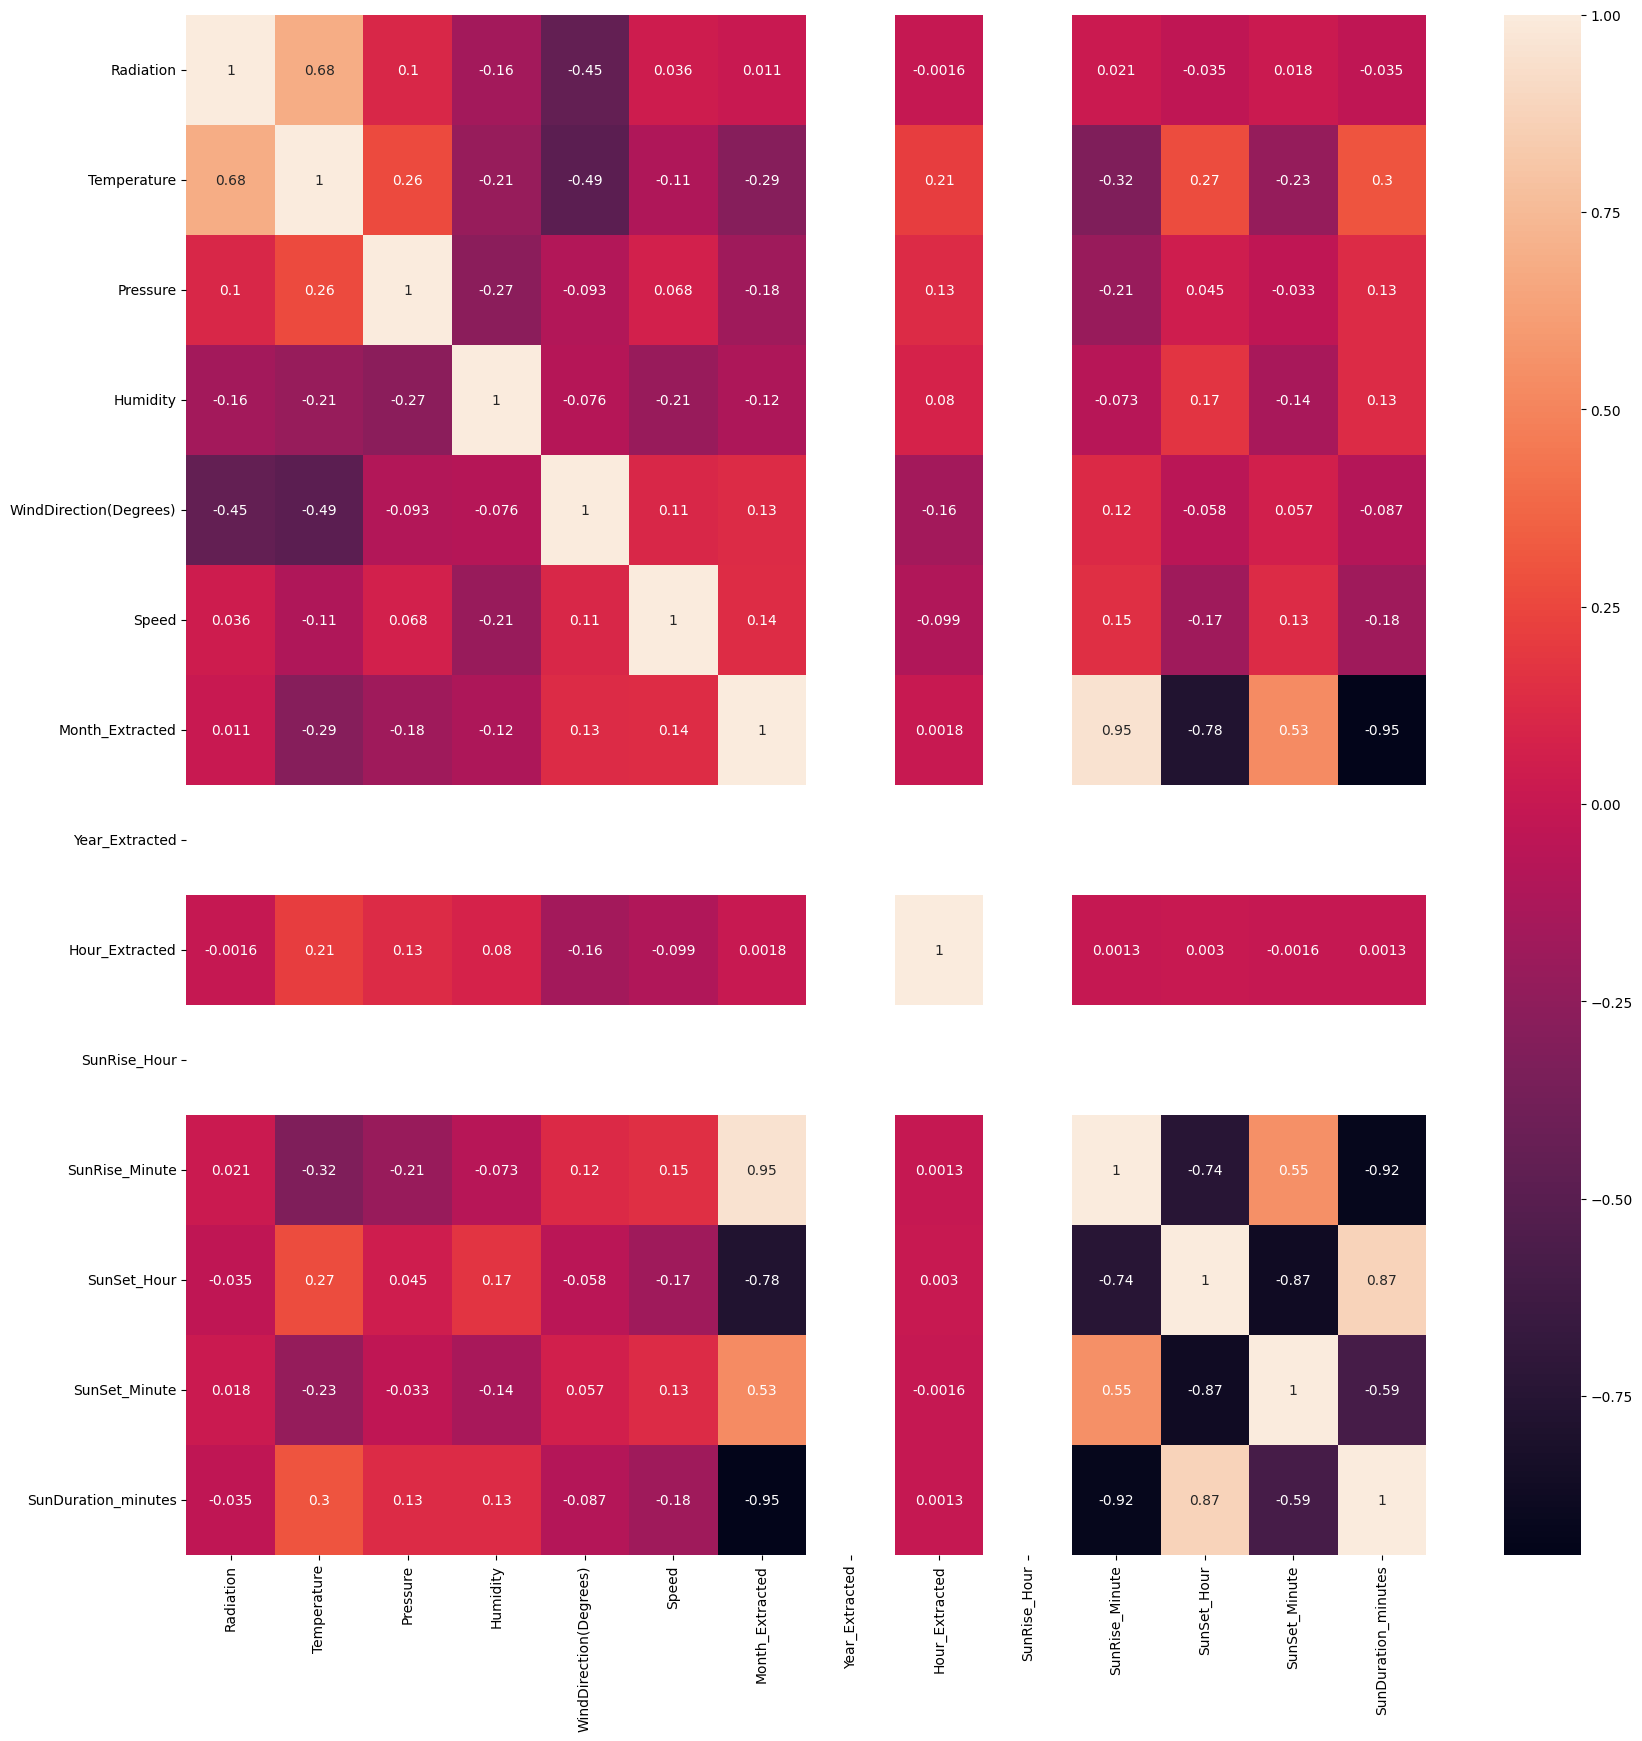

In [21]:
plt.figure(figsize=(20,20))
sns.heatmap(solar_df.corr(), annot = True)
plt.show()

In [22]:
input_features = solar_df.drop('Radiation', axis = 1)
target = solar_df['Radiation']

In [23]:
label_encoder = LabelEncoder()
train_Y = label_encoder.fit_transform(target)
target_cont = solar_df['Radiation'].apply(lambda x : int(x*100))

In [24]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
bestfeatures = SelectKBest(score_func = chi2, k = 10)
fit = bestfeatures.fit(input_features, target_cont)

In [25]:
import statsmodels.api as sm
X = input_features
y = target
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Radiation   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     3967.
Date:                Wed, 28 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:27:59   Log-Likelihood:            -1.7597e+05
No. Observations:               27164   AIC:                         3.520e+05
Df Residuals:                   27153   BIC:                         3.521e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Temperature               35

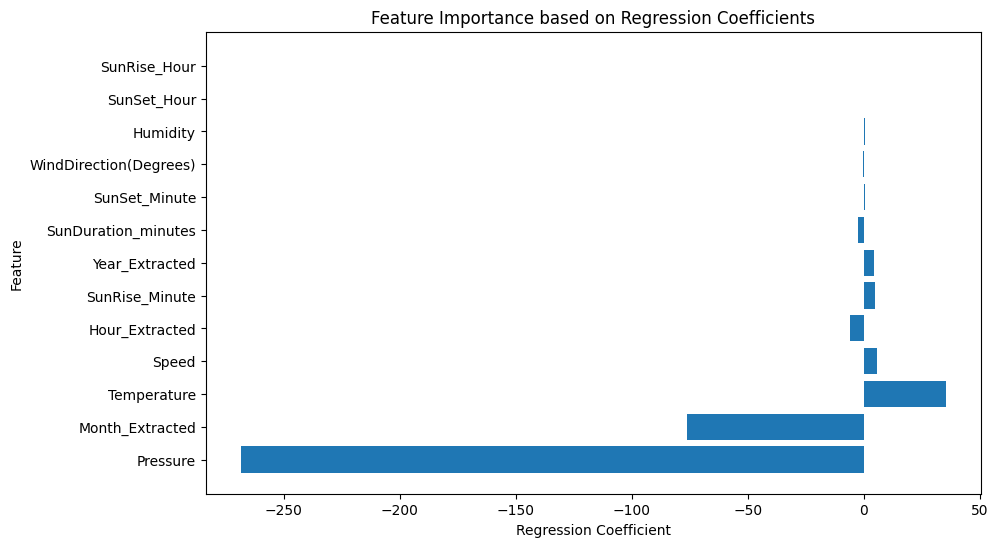

In [26]:

coefficients = model.params
# Sort the coefficients by absolute value in descending order
sorted_indices = np.argsort(np.abs(coefficients))[::-1]
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = coefficients.index[sorted_indices]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_coefficients)
plt.xlabel('Regression Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance based on Regression Coefficients')
plt.show()


In [27]:
sub_df = solar_df[['Temperature','Pressure','Month_Extracted','Speed','Year_Extracted','Hour_Extracted','SunRise_Minute','SunDuration_minutes','Radiation']]

### **LSTM IMPLEMENTATION**

In [28]:
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM #, Dense, Dropout
# from tensorflow.keras.optimizers import Adam

In [29]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(sub_df)


In [30]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :-1])
        y.append(data[i + seq_length, -1])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(scaled_df, seq_length)
# Split data into train and test sets
train_size = -10
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [31]:
X_train.shape

(27144, 10, 8)

In [32]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 8)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer=Adam(learning_rate=0.0001)
, loss='mse')

In [34]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0545 - val_loss: 0.0245
Epoch 2/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0281 - val_loss: 0.0259
Epoch 3/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0268 - val_loss: 0.0226
Epoch 4/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0239 - val_loss: 0.0278
Epoch 5/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0217 - val_loss: 0.0258
Epoch 6/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0194 - val_loss: 0.0237
Epoch 7/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0182 - val_loss: 0.0201
Epoch 8/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0164 - val_loss: 0.0245
Epoch 9/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0143 - val_loss: 0.0246
Epoch 10/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0139 - val_loss: 0.0241
Epoch 11/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0131 - val_loss: 0.0184
Epoch 12/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 

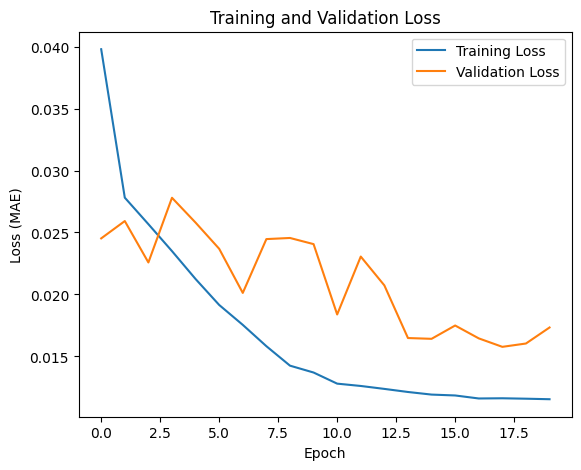

In [35]:

# Plot the training and validation loss and metric
plt.figure(figsize=(14, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()


In [36]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.0011e-05
Test Loss: 1.0011280210164841e-05


In [37]:
predictions = model.predict(X_test)
y_pred = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], predictions), axis=1))[:, -1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


In [38]:
# from sklearn.metrics import mean_squared_error
mse_lstm = mean_squared_error(y_test, predictions, squared=False)
print(f'Mean Squared Error (MSE): {mse_lstm}')

Mean Squared Error (MSE): 0.003164060849614841


In [39]:
# Calculate accuracy percentage for LSTM
accuracy_lstm = 100 - (mse_lstm / solar_data['Radiation'][-10:].mean()) * 100
print('LSTM Accuracy Percentage:', accuracy_lstm)

LSTM Accuracy Percentage: 99.73610835282612


### **CNN MODEL IMPLEMENTATION**

In [58]:
sub_df.isnull().sum()

,0
Temperature,0
Pressure,0
Month_Extracted,0
Speed,0
Year_Extracted,0
Hour_Extracted,0
SunRise_Minute,0
SunDuration_minutes,0
Radiation,0


In [40]:
x = sub_df[['Temperature', 'Pressure', 'Month_Extracted', 'Speed', 'Year_Extracted',
       'Hour_Extracted', 'SunRise_Minute', 'SunDuration_minutes']]

y= sub_df['Radiation']

In [59]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=1)

scaler =  MinMaxScaler(feature_range=(0, 1))
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [60]:
xtrain.shape, xtest.shape

((21731, 8), (5433, 8))

In [61]:
x_train_reshaped = xtrain.reshape((xtrain.shape[0], xtrain.shape[1], 1))
x_test_reshaped = xtest.reshape((xtest.shape[0], xtest.shape[1], 1))

In [44]:
# Define the CNN1D model
model = Sequential()

# Add Conv1D layer
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(8, 1), padding='same'))


# Flatten the output for Dense layers
model.add(Flatten())

# Add Dense layers
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='mae'
)

# Print the summary of the model
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 8, 32)               │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,705 (65.25 KB)

 Trainable params: 16,705 (65.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [45]:
history = model.fit(
    x_train_reshaped, ytrain,
    epochs=50,
    batch_size=32,
    validation_data=(x_test_reshaped, ytest)
)

Epoch 1/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 101.1600 - val_loss: 52.6020
Epoch 2/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 51.7601 - val_loss: 47.3840
Epoch 3/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 48.0085 - val_loss: 49.0406
Epoch 4/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 47.4007 - val_loss: 44.5533
Epoch 5/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 46.0000 - val_loss: 44.0323
Epoch 6/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 44.6351 - val_loss: 45.4828
Epoch 7/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 45.6129 - val_loss: 44.0657
Epoch 8/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 46.7619 - val_loss: 44.8054
Epoch 9/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 45.3567 - val_loss: 43.1425
Epoch 10/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 44.7757 - val_loss: 43.6337
Epoch 11/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 44.5589 - val_loss: 47.9945
Epoch 12/50
680/680 ━━━━━━━━━

In [46]:
ytrain.shape

(21731,)

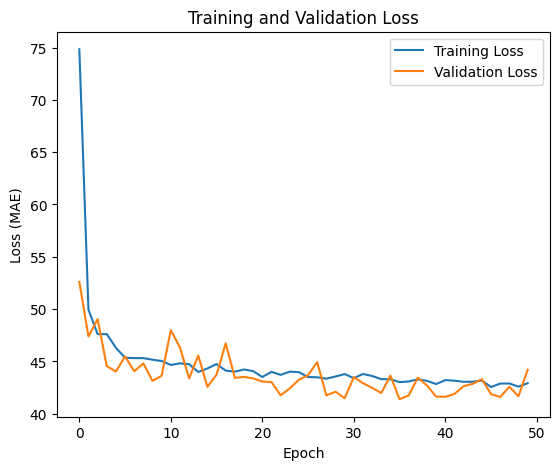

In [47]:

# Plot the training and validation loss and metric
plt.figure(figsize=(14, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()


plt.show()

In [48]:
loss = model.evaluate(x_test_reshaped, ytest)
print(f'Test Loss: {loss}')

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43.3458
Test Loss: 44.20658874511719


In [49]:
predictions_cnn = model.predict(x_test_reshaped)

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [50]:
mse_cnn = mean_squared_error(ytest, predictions_cnn, squared=False)
print(f'Mean Squared Error (MSE): {mse_cnn}')

Mean Squared Error (MSE): 92.76217013425192


In [51]:
# Calculate accuracy percentage for LSTM
accuracy_cnn = 100 - (mse_cnn / ytest.mean()) * 100
print('LSTM Accuracy Percentage:', accuracy_cnn)

LSTM Accuracy Percentage: 38.22003755396379


### **Random Forest Implementation**

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [53]:
X = sub_df.drop('Radiation', axis=1)
y = sub_df['Radiation']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [54]:
# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# # Fit the model to the training data
# rf_model.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred_rf = rf_model.predict(X_test)


In [55]:
# # Evaluate the model
# mse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
# print(f'Mean Squared Error (MSE): {mse_rf}')

# # Calculate accuracy percentage for Random Forest
# accuracy_rf = 100 - (mse_rf / y_test.mean()) * 100
# print('Random Forest Accuracy Percentage:', accuracy_rf)


In [56]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END max_de

In [57]:
# Create a new Random Forest model with the best parameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)

# Fit the best model to the training data
best_rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluate the best model
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf, squared=False)
print(f'Mean Squared Error (Best Model): {mse_best_rf}')

# Calculate accuracy percentage for the best Random Forest model
accuracy_best_rf = 100 - (mse_best_rf / y_test.mean()) * 100
print('Best Random Forest Accuracy Percentage:', accuracy_best_rf)


Mean Squared Error (Best Model): 64.61415308834863
Best Random Forest Accuracy Percentage: 56.930777812681185
